In [1]:
# MODIFY! 
# use RobustScaler! 
model_name = 'rf-no'

# Import Libraries & Data 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./data/d-no-ns.csv')
X = df.drop('throughput',axis=1)
y = df['throughput']

---

# Scale Data

In [4]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the data
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler()

In [5]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Determine Hyperparameters

## Determine Max Features

In [6]:
# MODIFY!
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(warm_start=True)
model

RandomForestRegressor(warm_start=True)

In [7]:
p_grid = {
    'max_features':['auto', 'sqrt', 'log2']
}

In [8]:
from sklearn.model_selection import GridSearchCV

In [9]:
grid_model = GridSearchCV(
    estimator=model,
    param_grid =p_grid, 
    scoring='neg_mean_squared_error',
    cv=10, 
    verbose=1
)

In [10]:
grid_model.fit(X_train,y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   26.6s finished


GridSearchCV(cv=10, estimator=RandomForestRegressor(warm_start=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2']},
             scoring='neg_mean_squared_error', verbose=1)

In [11]:
grid_model.best_params_

{'max_features': 'auto'}

In [12]:
hp = pd.Series(name=f'{model_name} HP', data=grid_model.best_params_)

In [13]:
hp

max_features    auto
Name: rf-no HP, dtype: object

In [14]:
hp.to_csv(f'./hyperparameters/{model_name}.csv')

## Determine Number of Estimators

In [15]:
# MODIFY!
import time

estimators = [5,10,25,50,100,500,1000,2000]
scores_list = []

from sklearn.ensemble import RandomForestRegressor

for e in estimators: 
    start = time.time()
    print(f'Starting {e} estimators')
    score_model = RandomForestRegressor(
        n_estimators=e,
        max_features=grid_model.best_params_['max_features']
    )
    
    from sklearn.model_selection import cross_validate

    scores = cross_validate(
        score_model, 
        X_train, 
        y_train,
        scoring=[
            'neg_mean_absolute_error',
            'neg_mean_squared_error',
            'neg_root_mean_squared_error'
        ],
        cv=10
    )
    
    scores = pd.DataFrame(scores)
    scores
    mean_scores = scores.mean()
    scores_list.append(mean_scores)
    print(f'Done with {e} estimators')
    end = time.time()
    print(f'Elapsed time: {end - start}')
    print('\n')

Starting 5 estimators
Done with 5 estimators
Elapsed time: 1.0114338397979736


Starting 10 estimators
Done with 10 estimators
Elapsed time: 1.8217847347259521


Starting 25 estimators
Done with 25 estimators
Elapsed time: 4.627111911773682


Starting 50 estimators
Done with 50 estimators
Elapsed time: 8.475919723510742


Starting 100 estimators
Done with 100 estimators
Elapsed time: 16.68836522102356


Starting 500 estimators
Done with 500 estimators
Elapsed time: 83.07509016990662


Starting 1000 estimators
Done with 1000 estimators
Elapsed time: 168.91816806793213


Starting 2000 estimators
Done with 2000 estimators
Elapsed time: 437.05894780158997




In [16]:
scores_df = pd.DataFrame(scores_list)

In [17]:
scores_df

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.097236,0.003048,-3.317039,-20.340872,-4.499399
1,0.178291,0.003041,-3.211471,-18.382860,-4.280919
2,0.454885,0.006628,-3.080912,-17.274078,-4.144729
3,0.838230,0.007674,-3.043685,-17.218653,-4.136652
4,1.653710,0.012765,-3.011643,-16.752449,-4.085274
5,8.239485,0.059555,-3.003494,-16.665203,-4.072814
6,16.755676,0.118415,-3.007113,-16.660734,-4.072567
7,43.037821,0.619533,-3.004186,-16.613942,-4.066401


In [18]:
scores_df['Est'] = estimators

In [19]:
scores_df

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,Est
0,0.097236,0.003048,-3.317039,-20.340872,-4.499399,5
1,0.178291,0.003041,-3.211471,-18.382860,-4.280919,10
2,0.454885,0.006628,-3.080912,-17.274078,-4.144729,25
3,0.838230,0.007674,-3.043685,-17.218653,-4.136652,50
4,1.653710,0.012765,-3.011643,-16.752449,-4.085274,100
5,8.239485,0.059555,-3.003494,-16.665203,-4.072814,500
6,16.755676,0.118415,-3.007113,-16.660734,-4.072567,1000
7,43.037821,0.619533,-3.004186,-16.613942,-4.066401,2000


# Export Scores for Number of Estimators

In [20]:
# mean_scores

In [21]:
scores_df = scores_df.rename(columns={
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [22]:
scores_df

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,0.097236,0.003048,-3.317039,-20.340872,-4.499399,5
1,0.178291,0.003041,-3.211471,-18.382860,-4.280919,10
2,0.454885,0.006628,-3.080912,-17.274078,-4.144729,25
3,0.838230,0.007674,-3.043685,-17.218653,-4.136652,50
4,1.653710,0.012765,-3.011643,-16.752449,-4.085274,100
5,8.239485,0.059555,-3.003494,-16.665203,-4.072814,500
6,16.755676,0.118415,-3.007113,-16.660734,-4.072567,1000
7,43.037821,0.619533,-3.004186,-16.613942,-4.066401,2000


In [23]:
scores_df[['MAE','MSE','RMSE']] = scores_df[['MAE','MSE','RMSE']].apply(lambda x : abs(x))

In [24]:
scores_df
# we go for 25 estimations. Note that from 25 -> 50 estimations the error metrics worsen

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,0.097236,0.003048,3.317039,20.340872,4.499399,5
1,0.178291,0.003041,3.211471,18.382860,4.280919,10
2,0.454885,0.006628,3.080912,17.274078,4.144729,25
3,0.838230,0.007674,3.043685,17.218653,4.136652,50
4,1.653710,0.012765,3.011643,16.752449,4.085274,100
5,8.239485,0.059555,3.003494,16.665203,4.072814,500
6,16.755676,0.118415,3.007113,16.660734,4.072567,1000
7,43.037821,0.619533,3.004186,16.613942,4.066401,2000


In [25]:
scores_df.to_csv(f'./est-scores/{model_name}-est.csv')

In [26]:
pct_scores_df = scores_df.pct_change()

In [27]:
pct_scores_df

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.833596,-0.002315,-0.031826,-0.096260,-0.048558,1.0
2,1.551369,1.179233,-0.040654,-0.060316,-0.031813,1.5
3,0.842727,0.157887,-0.012083,-0.003209,-0.001949,1.0
4,0.972860,0.663352,-0.010527,-0.027076,-0.012420,1.0
5,3.982424,3.665631,-0.002706,-0.005208,-0.003050,4.0
6,1.033583,0.988322,0.001205,-0.000268,-0.000061,1.0
7,1.568552,4.231894,-0.000973,-0.002809,-0.001514,1.0


In [28]:
pct_scores_df.style.background_gradient() 
# we choose index 4, 100 Estimations <- 
    # Score time decrease 3->4 & Score time increase dramatically 4->5
    # unsubstantial decrease MSE & RMSE 4->5 compared to 3->4

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,nan,nan,nan,nan,nan,nan
1,0.833596,-0.002315,-0.031826,-0.096260,-0.048558,1.000000
2,1.551369,1.179233,-0.040654,-0.060316,-0.031813,1.500000
3,0.842727,0.157887,-0.012083,-0.003209,-0.001949,1.000000
4,0.972860,0.663352,-0.010527,-0.027076,-0.012420,1.000000
5,3.982424,3.665631,-0.002706,-0.005208,-0.003050,4.000000
6,1.033583,0.988322,0.001205,-0.000268,-0.000061,1.000000
7,1.568552,4.231894,-0.000973,-0.002809,-0.001514,1.000000


# Score Model

In [29]:
# MODIFY!
# adopt number of estimators from the previous section

score_model = RandomForestRegressor(n_estimators=100)
score_model

RandomForestRegressor()

In [30]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    score_model, 
    X_train, 
    y_train,
    scoring=[
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error'
    ],
    cv=10
)

In [31]:
scores = pd.DataFrame(scores)

In [32]:
scores

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,3.594694,0.020539,-3.025981,-16.937375,-4.115504
1,3.694014,0.126479,-2.930191,-16.270971,-4.033729
2,2.699417,0.018463,-3.295049,-19.647355,-4.432534
3,3.093568,0.021622,-3.100217,-19.043167,-4.363848
4,2.459038,0.019697,-2.805757,-14.579730,-3.818341
5,2.233301,0.018906,-3.304750,-18.002667,-4.242955
6,2.255771,0.019500,-3.415751,-21.504969,-4.637345
7,3.619218,0.030275,-3.001526,-15.556509,-3.944174
8,2.947020,0.024195,-2.770823,-13.679615,-3.698596
9,2.666352,0.021942,-2.763363,-14.041958,-3.747260


In [33]:
mean_scores = scores.mean()

In [34]:
mean_scores

fit_time                             2.926239
score_time                           0.032162
test_neg_mean_absolute_error        -3.041341
test_neg_mean_squared_error        -16.926432
test_neg_root_mean_squared_error    -4.103429
dtype: float64

# Export Model Scores

In [35]:
mean_scores = mean_scores.rename(f'{model_name}')

In [36]:
mean_scores[[2,3,4]] = mean_scores[[2,3,4]].apply(abs)

In [37]:
# mean_scores

In [38]:
mean_scores = mean_scores.rename({
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [39]:
mean_scores

Fit Time       2.926239
Score Time     0.032162
MAE            3.041341
MSE           16.926432
RMSE           4.103429
Name: rf-no, dtype: float64

In [40]:
mean_scores['STD FT'] = scores.fit_time.std()
mean_scores['STD ST'] = scores.score_time.std()
mean_scores['STD MAE'] = scores.test_neg_mean_absolute_error.std()
mean_scores['STD MSE'] = scores.test_neg_mean_squared_error.std()
mean_scores['STD RMSE'] = scores.test_neg_root_mean_squared_error.std()

In [41]:
mean_scores

Fit Time       2.926239
Score Time     0.032162
MAE            3.041341
MSE           16.926432
RMSE           4.103429
STD FT         0.558959
STD ST         0.033321
STD MAE        0.235119
STD MSE        2.596595
STD RMSE       0.313236
Name: rf-no, dtype: float64

In [42]:
mean_scores.to_csv(f'./scores/{model_name}.csv')

# Holdout Test

In [43]:
score_model.fit(X_train,y_train)

RandomForestRegressor()

In [44]:
y_holdout = score_model.predict(X_test)

<AxesSubplot:ylabel='Count'>

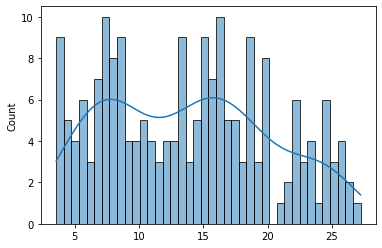

In [45]:
sns.histplot(y_holdout,bins=40,kde=True)

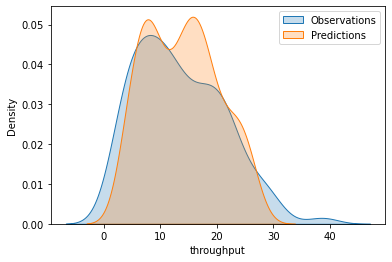

In [46]:
fig,ax = plt.subplots()

sns.kdeplot(y_test, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_holdout, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

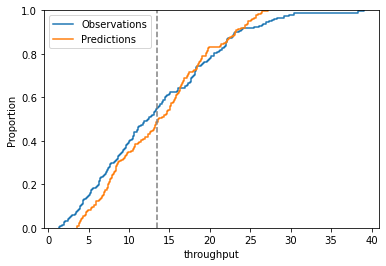

In [47]:
fig,ax = plt.subplots()

sns.ecdfplot(y_test, ax=ax, label='Observations')
sns.ecdfplot(y_holdout, ax=ax,label='Predictions')
plt.axvline(x=y_test.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test,y_holdout)
mse = mean_squared_error(y_test,y_holdout)
rmse = np.sqrt(mse)

In [49]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,rf-no
MAE,3.045528
MSE,17.464225
RMSE,4.179022


In [50]:
err_df.to_csv(f'./holdout-test/{model_name}.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [51]:
res = y_test - y_holdout
res.describe().drop('count')

mean    -0.382214
std      4.172055
min    -13.816107
25%     -2.731151
50%     -0.747411
75%      2.026176
max     15.122261
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

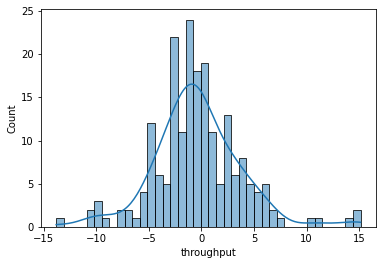

In [52]:
sns.histplot(data=res, kde=True,bins=40)

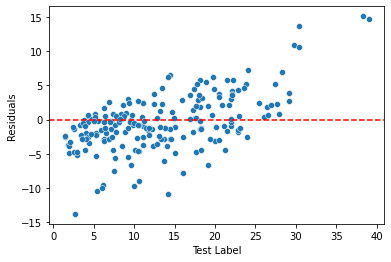

In [53]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

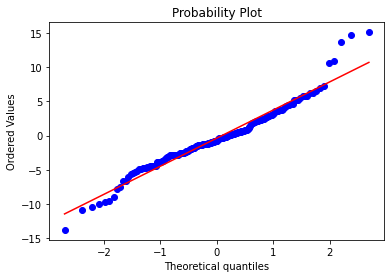

In [54]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

# Export Optimized Model

In [55]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X)

RobustScaler()

In [56]:
# MODIFY! 
X = scaler.transform(X)

op_model = score_model

op_model.fit(X,y)

RandomForestRegressor()

In [57]:
y_pred = op_model.predict(X)

<AxesSubplot:ylabel='Count'>

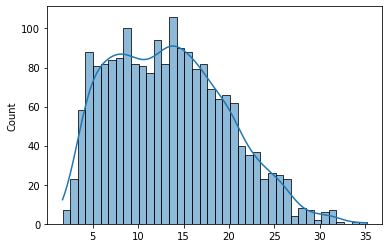

In [58]:
sns.histplot(y_pred,bins=40,kde=True)

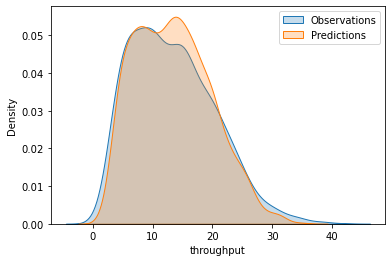

In [59]:
fig,ax = plt.subplots()

sns.kdeplot(y, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_pred, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

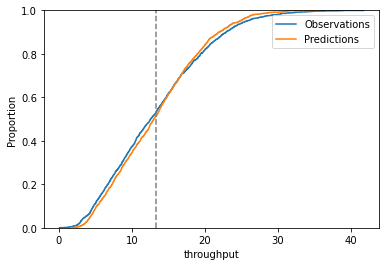

In [60]:
fig,ax = plt.subplots()

sns.ecdfplot(y, ax=ax, label='Observations')
sns.ecdfplot(y_pred, ax=ax,label='Predictions')
plt.axvline(x=y.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [61]:
mae = mean_absolute_error(y,y_pred)
mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)

In [62]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,rf-no
MAE,1.122994
MSE,2.392761
RMSE,1.546855


In [63]:
err_df.to_csv(f'./model-err/{model_name}.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [64]:
from joblib import dump, load
dump(op_model, f'./opt-models/{model_name}.joblib')

['./opt-models/rf-no.joblib']

In [65]:
res = y - y_pred
res.describe().drop('count')

mean   -0.036495
std     1.546816
min    -9.232075
25%    -0.874220
50%    -0.085099
75%     0.768447
max     6.951820
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

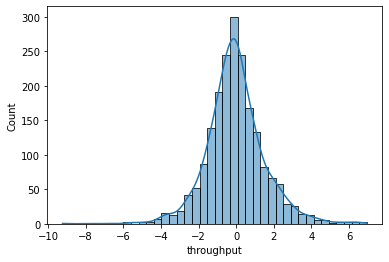

In [66]:
sns.histplot(data=res, kde=True,bins=40)

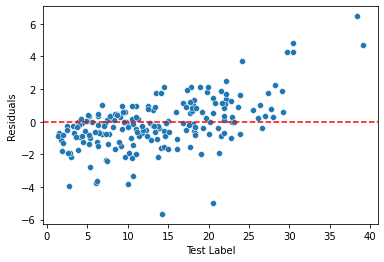

In [67]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

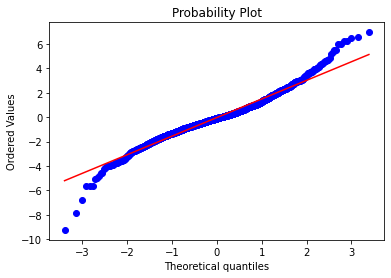

In [68]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

DONE!